##### Flake8 sur Jupyter :

On installe d'abord ceci : "pip install pycodestyle flake8 pycodestyle_magic"

On load la magic suivante

In [1]:
%load_ext pycodestyle_magic

Puis on commence une cellule par %%flake8 pour vérifier les erreurs

# The Social Network

# Librairies 

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage.interpolation import shift
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency,  spearmanr

from tqdm import tqdm

## Question 1

### Résultats Théoriques 

Le but est de représenter un réseau social non-orienté par une matrice symètrique,  et de simuler ces matrices sous une loi connue à une constante prêt : 
\begin{equation*}
    p(x|\theta) = \frac{1}{Z(\theta)}\exp^{\theta^{T} S(x)}
\end{equation*}
Où :
- x est la matrice en question,  évoluant dans $R^{n}$,  avec n le nombre d'individus
- S(x) est une statistique sur cette matrice. Nous prendrons le nombre d'arrêtes et le nombre de triangles (trois individus reliés les uns aux autres). Autrement dit : $S(x) = \big[ \sum_{i<j} x_{ij},  \sum_{i<j<k} x_{ij}x_{jk}x_{ki}\big].$ 
- $Z(\theta)$ est inconnue.
Nous pourrons ensuite trouver le paramètre sous-jacent à une observation.
Nous commençons par mettre en oeuvre un algorithme permettant de simuler x sous un $\theta$ donné.

#### Simulation par Gibbs Sampler

Afin de mettre en place cet algorithme,  nous devons trouver la loi de $x{ij}$ sachant $\theta$ et tous les autres coefficients de la matrice x (nous les noterons $x_{-ij}$). On a : $\forall i, j \text{ } \in \text{ } [\![1;n]\!]$

\begin{equation*}
\begin{split}
    \mathbf{P}(X_{ij} = 1 | \theta,  x_{-ij}) & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{-ij} = x_{-ij}} \\
    & = \frac{\mathbf{P}(X_{ij} = 1 \cap X_{-ij} = x_{-ij} |  \theta)}{\mathbf{P}(X_{ij} = 1,  X_{-ij} = x_{-ij}) + \mathbf{P}(X_{ij} = 0,  X_{-ij} = x_{-ij})}\\
    & = \frac{\exp^{\theta^{T} S_{1}(x)}}{\exp^{\theta^{T} S_{1}(x)} + \exp^{\theta^{T} S_{0}(x)}} \text{ ; en simplifiant par $Z(\theta)$ en haut et en bas} \\
    & = \frac{1}{1 + \exp^{\theta^{T} (S_{0}(x) - S_{1}(x))}}
\end{split}
\end{equation*}
où $S_{1}(x)$ est la statistique de la matrice x où $x_{ij}$ vaut 1,  et $S_{0}(x)$ la même chose mais pour $x_{ij}$ vallant 0.​

### Code

In [3]:
def s_consignes(m):
    '''
    La statistique donnée dans la consigne du projet.
    '''
    g = np.triu(m)

    return np.array([np.sum(g,  axis=(1, 2)),
                     np.sum(np.einsum('ijl, ilk->ijk', g, g)*g, axis=(1,  2))])

In [4]:
def gibbs_etape(x,  position,  u,  theta,  s):
    '''
    Input :

    x est la matrice à l'itération k du gibbs sampler,
    position est la liste [i, j] indiquant la position de la valeur à changer
    u une uniforme dans [0, 1] tirée au préalable
    theta et s sont ceux de la densité

    Output :

    matrice à l'itération k+1 du gibbs sampler
    '''

    m = x.shape[0]  # taille de la matrice

    y = x.copy()  # copies modifiables
    z = x.copy()

    y[position[0], position[1]] = 1
    z[position[0], position[1]] = 0

    s_1 = s(z.reshape(1, m, m))
    s_0 = s(y.reshape(1, m, m))

    y[position[0],
      position[1]] = (u < 1/(1 + np.exp(theta.dot(np.subtract(s_1, s_0)))))*1

    y[position[1],
      position[0]] = y[position[0], position[1]]

    return(y)

In [5]:
def pos(taille_finale, nb_individus):
    """
    Input :

    taille_finale la taille totale que l'on souhaite
    nb_individus le nombre d'individus dans le réseau

    Output :

    Toutes les positions à modifier
    """

    liste_positions = []

    for i in range(nb_individus):
        for j in range(i+1, nb_individus):
            liste_positions += [[i, j]]

    # Copies de la liste
    to_return_1 = liste_positions*(taille_finale//len(liste_positions))

    # Reste de la liste
    to_return_2 = liste_positions[:taille_finale % len(liste_positions)]

    return np.array(to_return_1 + to_return_2)

In [6]:
def gibbs(iterations,  nb_network,  theta,  stat,
          m_0='default', return_statistique=False, esp=1):
    """
    Input :

    iterations : le nombre d'itération dans le gibbs sampling
    nb_network : le nombre d'individus dans le réseau
    theta : un array pour les paramètres de la loi
    stat : une fonction vectorisable sur
    une liste de matrices (statistique exhaustive de notre loi)
    last_sample=True si on veut juste la dernière matrice
    esp : l'espace qud l'on veut entre chaque echantillon retourné

    """
    # Position des éléments que l'on veut
    indices_return = np.cumsum([esp]*(iterations//esp))

    if type(m_0) != np.ndarray:
        # Partir de 0
        m_0 = np.ones((nb_network, nb_network))-np.identity(nb_network)

    r = np.broadcast_to(m_0, (iterations+1, nb_network, nb_network))
    q = r.copy()

    indices = pos(iterations, nb_network)

    u = np.random.uniform(0, 1, iterations)

    for k in tqdm(range(iterations)):
        q[k+1] = gibbs_etape(q[k], indices[k], u[k], theta, stat)

    if return_statistique:
        return stat(q[indices_return])

    else:

        return q[indices_return]

In [7]:
def evolution(vecteur):
    '''
    Evolution moyenne empirique et intervalle de confiance
    asymptotique à 95 pourcent
    '''

    n = len(vecteur)

    x = np.array([i+1 for i in range(n)])

    moyenne_empi = np.cumsum(vecteur)/x

    vect_broad = np.broadcast_to(vecteur, (n, n))
    moy_broad = np.broadcast_to(moyenne_empi, (n, n))

    stdv_empi = np.ones((1, n)).dot((np.triu(vect_broad.T-moy_broad))**2)/x
    stdv_empi = np.sqrt(stdv_empi).reshape((n, ))

    ub = moyenne_empi + (stdv_empi*1.96)/(np.sqrt(x))
    lb = moyenne_empi - (stdv_empi*1.96)/(np.sqrt(x))

    plt.figure(figsize=(12, 5))
    plt.title(''' Evolution de la moyenne empirique du vecteur
              avec intervalle de confiance à 95%''')
    plt.plot(moyenne_empi,  color='firebrick')
    plt.fill_between(x,  ub,  lb, color='tomato', alpha=.35)

#### Trouver à quelle itération on a une simulation qui nous convient 

On propose deux méthodes : 

    -Regarder à quelle moment se stabilisent les composantes de la statistique S
    -Commencer l'algorithme de Gibbs Sampling avec différentes valeurs de départ et faire un test d'homogénéité avec Kolmogorov-Smirnov pour voir à quel moment les deux suites ont la meme loi.

In [8]:
def plot_stabilite_stat(vecteur, nb_shift=10):

    '''
    Permet de tracer l'évolution de la valeur de la statistique et
    de ses différences d'ordre nb_shift sur chacune de ses dimensions.
    '''

    fig,  axs = plt.subplots(nrows=2,  ncols=2)
    axs = axs.flatten()
    fig.subplots_adjust(hspace=0.5,  wspace=0.1)
    fig.set_size_inches(18.5,  7)

    # Differentes couleurs pour les plots
    colors = ['darkorange', 'darkmagenta']

    for i in range(2):

        axs[2*i].set_title('''Evolution de la composante
                    '''+str(i+1)+' de la statistique S')
        axs[2*i].plot(vecteur[i], color=colors[i % 2])

        svecteur = shift(vecteur[i],  nb_shift,  cval=0)
        axs[2*i+1].set_title('''Evolution des différences d'ordre
        '''+str(nb_shift)+' de la composante '+str(i+1)+' de la statistique S')
        axs[2*i+1].plot(vecteur[i]-svecteur, color=colors[i % 2])

In [9]:
# On choisit de faire tourner I itérations sur
# Gibbs pour générer des réseaux de nb_nods personnes

I = 1000
nb_nods = 16

In [10]:
%%time

# Matrice de départ aléatoire
r = np.triu(np.random.randint(2,
                              size=[nb_nods, nb_nods]), 1)

P_random = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                 s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 3473.94it/s]


Wall time: 339 ms


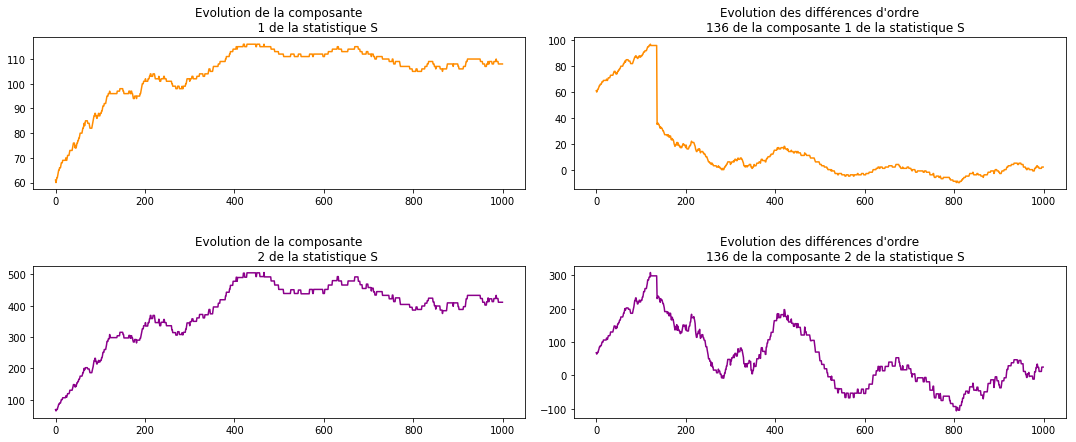

In [11]:
plot_stabilite_stat(P_random, nb_shift=nb_nods*(nb_nods+1)//2)

# 400 itérations semble raissonable avec matrice départ aléatoire

In [12]:
%%time

# Matrice de départ avec des 1 (sauf diagonale nulle)
r = np.ones([nb_nods, nb_nods])-np.identity(nb_nods)

P_ones = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
               s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 2925.67it/s]


Wall time: 404 ms


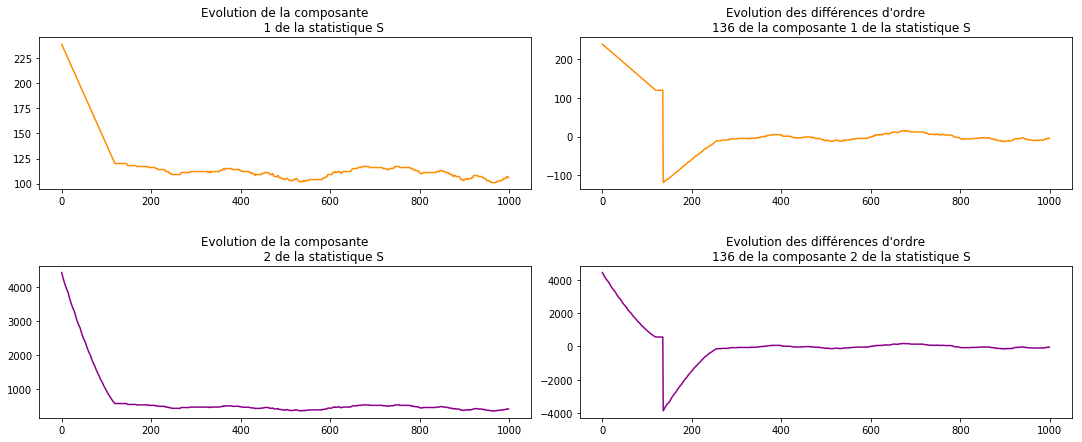

In [13]:
plot_stabilite_stat(P_ones, nb_shift=nb_nods*(nb_nods+1)//2)

In [14]:
%%time
# Matrice de départ avec des 0
r = np.ones([nb_nods, nb_nods])*0 

P_nulles = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r+r.T, return_statistique=True,  esp=1)

100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 2578.77it/s]


Wall time: 449 ms


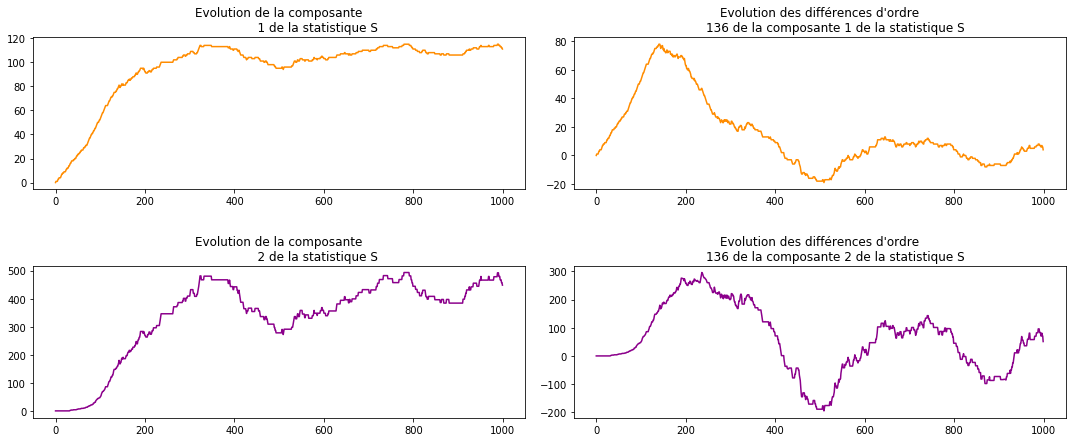

In [15]:
plot_stabilite_stat(P_nulles, nb_shift=nb_nods*(nb_nods+1)//2)

##### Kolmogorov-Smirnov

In [16]:
def plot_pvaleur_ks_continu(vecteur1, vecteur2, size_sample=100):

    plt.figure(figsize=(12, 5))

    if len(vecteur1) != len(vecteur2):
        print('Les deux vecteurs doivent être de même taille !')

    liste_plot = []

    for i in range(len(vecteur1)-size_sample):
        liste_plot += [ks_2samp(vecteur1[i:i+size_sample],
                                vecteur2[i:i+size_sample])[1]]

    plt.title('''Evolution de la p-valeur du test d'homogénéité de Kolmogorov-Smirnov en
    prenant continuement des echantillons de taille '''+str(size_sample)+'''
    le long des vecteurs en input''')

    plt.plot(liste_plot, color='limegreen')

In [17]:
%%time

I=10000
nb_nods=16

#ecart=(nb_nods*(nb_nods+1)//2)//10
ecart=10

r_1 = np.ones([nb_nods, nb_nods])-np.identity(nb_nods) #Matrice de départ avec 1 sauf sur diagonale

P_1 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r_1+r_1.T, return_statistique=True,  esp=ecart)

r_2 = np.ones([nb_nods, nb_nods])*0  #Matrice de départ avec 0

P_2 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),   s_consignes,  m_0=r_2+r_2.T, return_statistique=True,  esp=ecart)

100%|██████████████████████████████████| 10000/10000 [00:02<00:00, 4593.96it/s]


Wall time: 4.62 s


In [18]:
print("La taille de l'écart était de "+str(ecart)+" et la taille de l'échantillon est "+str(len(P_1[0])))

La taille de l'écart était de 10 et la taille de l'échantillon est 1000


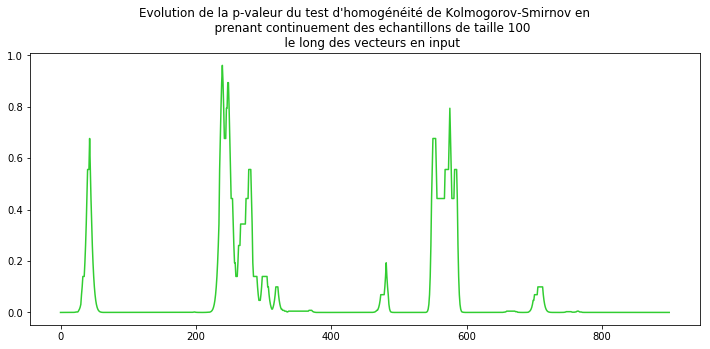

In [19]:
plot_pvaleur_ks_continu(P_1[0], P_2[0], size_sample=100)

On regarde à quel moment la p-valeur dépasse 0.1 et on multipli ce moment par l'écart chosit pour retrouver à quelle itération les variables suivent la même loi

Nota Bene : La continuité vient du fait que les paquets de variables aléatoires ne sont modifié que d'une valeure étape par étape 

Avec une procédure analogue on peut vérfier que nos échantillons font bien des variables qui suivent une même loi

In [20]:
def plot_pvaleur_ks_exclusif(vecteur1, vecteur2, size_sample=100):

    plt.figure(figsize=(12, 5))

    if len(vecteur1) != len(vecteur2):
        print('Les deux vecteurs doivent être de même taille !')
        return False

    liste_plot = []

    for i in range(len(vecteur1)//size_sample):
        to_test_1 = vecteur1[i*size_sample:(i+1)*size_sample]
        to_test_2 = vecteur2[i*size_sample:(i+1)*size_sample]
        liste_plot += [ks_2samp(to_test_1, to_test_2)[1]]

    plt.title('''Evolution de la p-valeur du test d'homogénéité de Kolmogorov-Smirnov en
    prenant des echantillons disjoins de taille '''+str(size_sample)+'''
    le long des vecteurs en input''')

    plt.plot(liste_plot, color='darkcyan')

In [21]:
%%time

Run_This_Cell = False  # Peut mettre jusqu'à 10 minutes à tourner

if Run_This_Cell:

    I = 1000000
    nb_nods = 16

    ecart = (nb_nods*(nb_nods+1)//2)

# Matrice de départ avec 1 sauf sur diagonale
    r_1 = np.ones([nb_nods, nb_nods])-np.identity(nb_nods)

    P_1 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                s_consignes,  m_0=r_1+r_1.T,
                return_statistique=True,  esp=ecart)

# Matrice de départ avec 0
    r_2 = np.ones([nb_nods, nb_nods])*0

    P_2 = gibbs(I,  nb_nods,  np.array([0.1, 0.2]),
                s_consignes,  m_0=r_2+r_2.T,
                return_statistique=True,  esp=ecart)

    print("La taille de l'écart était de "+str(ecart))
    print(" et la taille de l'échantillon est "+str(len(P_1[0])))

    plot_pvaleur_KS_exclusif(P_1[0], P_2[0], size_sample=100)

Wall time: 0 ns


#### A quel moment nos echantillons sont-ils suffisament "indépendants" ?

In [22]:
def plot_pvaleur_spearman(vect, effectif=100,  echantillons_distincts=True):

    plt.figure(figsize=(12, 8))

    liste_plot = []

    premier_index_test = True

    if echantillons_distincts:
        for n in range(len(vect)//effectif):

            p_value = spearmanr(vect[:effectif],
                                vect[effectif*n+1:effectif*(n+1)+1])[1]
            liste_plot += [p_value]

            if premier_index_test and p_value > 0.1:
                print("On ne rejette pas le test en "+str(n)+" .")
                print('''0n multipli ce nombre à l'écart choisit dans le Gibbs Sample
                pour savoir au bout de combient
                d'itération on est indépendant.''')
                premier_index_test = False

    else:
        for n in range(len(vect)-effectif):

            p_value = spearmanr(vect[0:effectif], vect[n:effectif+n])[1]
            liste_plot += [p_value]

            if premier_index_test and p_value > 0.1:
                print("On ne rejette pas le test en "+str(n)+" .")
                print('''0n multipli ce nombre à l'écart choisit dans le Gibbs Sample
                pour savoir au bout de combient
                d'itération on est indépendant.''')
                premier_index_test = False

    plt.title('''Evolution de la p-valeur du test d'indépendance de Spearman
    en prenant des echantillons de taille '''+str(effectif)+'''
    le long de vecteur''')
    plt.plot(liste_plot, 'o',  color='darkred')

In [23]:
# On veut notre nouvelle matrice d'initialisation

X_0 = np.ones([16, 16])-np.identity(16)

M = gibbs(500,  16,  np.array([0.1, 0.2]),
          s_consignes,  m_0=X_0,  return_statistique=False,  esp=1)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 2908.66it/s]


In [24]:
X_0 = M[-1]

P = gibbs(10000,  16,  np.array([0.1, 0.2]),   s_consignes,  m_0 = X_0,  return_statistique=True,  esp=30)

100%|██████████████████████████████████| 10000/10000 [00:02<00:00, 4568.78it/s]


On ne rejette pas le test en 5 .
0n multipli ce nombre à l'écart choisit dans le Gibbs Sample
                pour savoir au bout de combient
                d'itération on est indépendant.


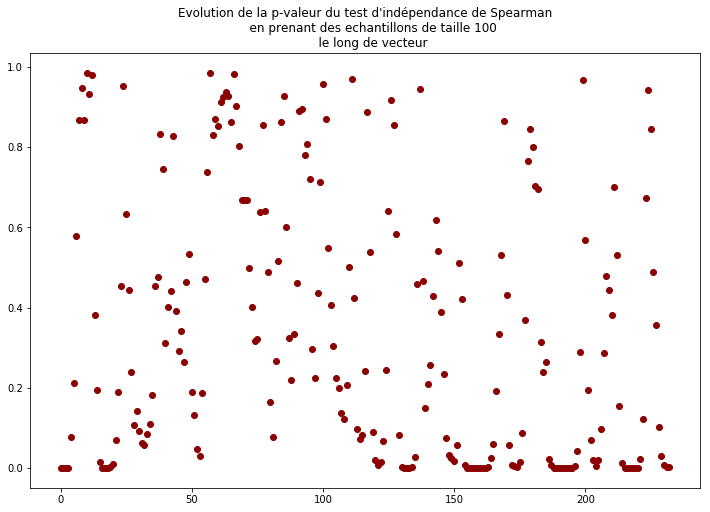

In [25]:
plot_pvaleur_spearman(P[0], echantillons_distincts=False)

# Ici on est indépendant au bout de 8 * 30 = 240 itérations

Pour aller plus loin : 

Il aurait été interessant de tester l'indépendance entre plusieurs matrices en testant l'indépendance de leurs coefficients ayant la même position. On aurait donc $\frac{(N-1) \times N}{2}$ tests d'indépendance à faire. On pourrait donc utiliser la procédure de Benjamini-Hochberg pour gérer ces tests multiples.

On peut maintenant observer l'évolution de nos estimateurs de Monte Carlo pour la statistique de la consigne

In [26]:
%%time

X_0 = M[-1]

X = gibbs(30000,  16,  np.array([0.1, 0.2]),   s_consignes,  m_0 = X_0,  return_statistique=True,  esp=120)

100%|██████████████████████████████████| 30000/30000 [00:08<00:00, 3493.21it/s]


Wall time: 8.75 s


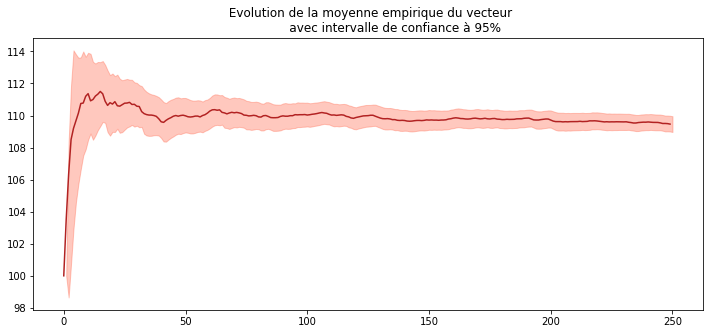

In [27]:
evolution(X[0])  # Le nombre d'arrêtes

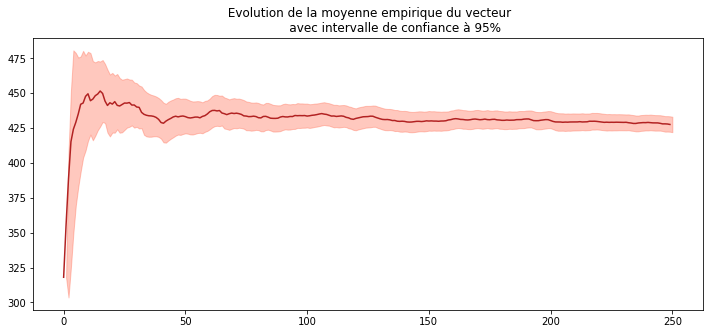

In [28]:
evolution(X[1])  # Le nombre de triangles

## Question 2

## Question 3